Scoring the models and visualising the scores

In [1]:
from pathlib import Path
from matplotlib.patches import Patch
import os
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..') # .\SAE\
os.getcwd()
fig_path = Path("./figures/")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

import numpy as np
import torch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

%matplotlib inline

# ------- internal imports
from models import GenerativeAE
import models, metrics, experiments, datasets
from metrics import score_disentanglement 
from experiments import EvaluationManager
from experiments.EvaluationManager import ModelHandler, VisualModelHandler, VectorModelHandler
from datasets import synth_dataset 
import visualisations
from visualisations import ModelVisualiser, SynthVecDataVisualiser
from visualisations import visualise_data, visualise_model

## All scores

In [2]:
full_df = pd.read_csv("./logs/all_scores.csv", index_col=0)

In [3]:
full_df

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,MIG,ModExp,SAP,FID_rec,FID_gen,INV,EQV,SCN
0,XAE,standardS_MNIST,MNIST,11,0.002132,0.016094,-33.006348,0.168828,NaN,0.697563,0.019787,NaN,0.014,83.664420,79.319353,20.069971,34.183556,5.257522
1,XSAE,standardS_MNIST,MNIST,11,0.002425,0.019672,-34.468983,0.208302,NaN,0.655058,0.043108,NaN,0.030,83.344602,80.920696,20.926472,33.319210,5.416009
2,XVAE,standard_MNIST,MNIST,11,0.001532,0.010943,-40.491798,0.044166,NaN,0.561657,0.053095,NaN,0.150,83.489574,82.737247,116.087585,143.599945,4.823517
3,XSAE,standard_MNIST,MNIST,11,0.002434,0.014305,-52.094749,0.090750,NaN,0.551446,0.042508,NaN,0.042,80.746022,77.984038,90.275177,137.146759,11.070246
4,XAE,standard_MNIST,MNIST,11,0.002346,0.013762,-38.723152,0.067907,NaN,0.514539,0.046793,NaN,0.008,78.020279,77.349419,81.108719,139.013794,11.334163
5,XVAE,standardS_MNIST,MNIST,11,0.001375,0.010875,-44.118690,0.155311,NaN,0.608827,0.099314,NaN,0.026,82.714821,82.557220,25.643082,35.740990,3.228109
6,XCVAE,standardS_MNIST,MNIST,11,0.001658,0.012032,-51.224442,0.213489,NaN,0.512690,0.176448,NaN,0.098,83.720304,83.107080,23.898449,34.815960,2.276694
7,XCAE,standardS_MNIST,MNIST,11,0.001935,0.015342,-37.850975,0.187408,NaN,0.645474,0.033334,NaN,0.014,84.894211,79.367658,24.636612,34.959793,5.413826
8,XCSAE,standardS_MNIST,MNIST,11,0.002217,0.017342,-38.541573,0.216116,NaN,0.639433,0.175404,NaN,0.034,85.712767,82.037947,22.642763,33.757912,5.400022
9,XCVAE,standardSE_MNIST,MNIST,11,0.001476,0.011642,-50.894958,0.217245,NaN,0.487654,0.162633,NaN,0.128,83.000928,82.957890,25.378368,35.562134,3.824248


# Disentanglement scoring 

## Visual datasets

In [36]:
#load all scores and save them in lists 
#extract relevan numbers from the lists and form a df
# plot df with seaborn
model_names =  ["XSAE"]#,"RSAE","RAE","AE","BetaVAE"]
model_versions = [["standardS"]]
                  #, ["standardS", "standard","v121"], 
                  #["standardS", "standard","v121"],["standardS", "standard","v121"], 
                  #["standardS", "standard"]]

In [2]:
# X-class models
model_names = ["XAE","XSAE"]#,"XVAE","XCAE", "XCSAE"
model_versions = [["uniform","multidim"]]*2
#model_versions = [["standardS","standard","v121"]]*3 + [["standardS"]]*2

In [37]:
model_params=[]
for i,model_n in enumerate(model_names): 
    for model_v in model_versions[i]:
        _params = {"model_name":model_n,
                   "model_version":model_v,
                   "data":"MNIST" if model_v!="v121" else "3DS"}
        model_params.append(_params)

In [38]:
scores=[]
for params in model_params:
        handler = (ModelHandler.from_config(**params, verbose=False))
        handler.config["logging_params"]["save_dir"] = "./logs"
        scores.append(handler.load_scores(name="scoring"))

configs/models/XSAE/standardS.yaml
Initialising schedulers Manager...
Explicit mode ON
XSAE model hanlder loaded.


In [39]:
# fill the dataframe
scores_df = pd.DataFrame()
scores_df["model_name"] = [params["model_name"] for params in model_params]
scores_df["model_version"] = [params["model_version"] for params in model_params]
scores_df["dataset"] = [params["data"] for params in model_params]
for i,score_set in enumerate(scores):
    try: 
        for k,v in score_set.items():
            scores_df.loc[i,k] = v
    except AttributeError: 
        continue

In [40]:
scores_df.drop("CAT", axis=1)

,model_name,model_version,dataset,RBF,IMQ,dCOV,DCI,IRS,MIG,ModExp,SAP,FID
0,XSAE,standardS,MNIST,0.003097,0.018545,0.265934,NaN,0.694465,0.042998,NaN,0.014,28.780144


In [43]:
full_df.to_csv("Scores_full.csv")

In [28]:
full_df = pd.read_csv("Scores_full.csv", index_col=0)

In [41]:
full_df = pd.concat([scores_df, full_df], ignore_index=True)

c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [42]:
full_df

,CAT,DCI,FID,IMQ,IRS,MIG,ModExp,RBF,SAP,dCOV,dataset,model_name,model_version
0,-56.818623,NaN,28.780144,0.018545,0.694465,0.042998,NaN,0.003097,0.014000,0.265934,MNIST,XSAE,standardS
1,-163.742264,0.819014,30.991769,0.012457,0.641158,0.385582,0.930223,0.002005,0.132333,0.329517,3DS,XSAE,v121
2,-108.748917,NaN,23.357188,0.013519,0.509226,0.050385,NaN,0.002267,0.044000,0.154872,MNIST,XSAE,standard
3,-100.753990,NaN,23.411017,0.012398,0.524709,0.001706,NaN,0.001882,0.038000,0.143742,MNIST,XCSAE,standard
4,-57.079391,NaN,22.838230,0.013017,0.516027,0.008658,NaN,0.002075,0.044000,0.075921,MNIST,XAE,uniform
5,-96.858383,NaN,21.827783,0.011469,0.466371,0.007777,NaN,0.001978,0.014000,0.053683,MNIST,XAE,multidim
6,-88.436607,NaN,23.470231,0.013661,0.580276,0.022948,NaN,0.002178,0.022000,0.136615,MNIST,XSAE,uniform
7,-103.739120,NaN,22.367383,0.011744,0.505433,0.008245,NaN,0.002169,0.002000,0.061390,MNIST,XSAE,multidim
8,-48.296021,NaN,28.713507,0.017033,0.657263,0.049121,NaN,0.002306,0.018000,0.172199,MNIST,XAE,standardS
9,-68.324272,NaN,22.886947,0.011703,0.556465,0.072207,NaN,0.001695,0.006000,0.076834,MNIST,XAE,standard


## Vector datasets

In [42]:
#load all scores and save them in lists 
#extract relevan numbers from the lists and form a df
# plot df with seaborn
data_versions = ["standard","discrete","continuous","big"]
model_names = ["VecESAE","VecSAE","VecVAE","VecRSAE","VecRAE","VecAE"]

model_versions = [["standard"], ["standard", "full"], ["standard"], ["standard","full"], ["standard"], ["standard"]]

model_params=[]
for data_v in data_versions:
    for i,model_n in enumerate(model_names): 
        for model_v in model_versions[i]:
            _params = {"model_name":model_n,
                       "model_version":model_v,
                       "data":"SynthVec",
                       "data_version":data_v}
            model_params.append(_params)

In [43]:
# collect the handlers
scores=[]
for params in model_params:
        handler = (VectorModelHandler.from_config(**params, verbose=False))
        handler.config["logging_params"]["save_dir"] = "./logs"
        scores.append(handler.load_scores(name="scoring_noises"))

----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecESAE model hanlder loaded.
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecSAE model hanlder loaded.
configs/models/VecSAE/full.yaml
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading meta

VecVAE model hanlder loaded.
----------Opening SynthVec dataset version continuous / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version continuous / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecRSAE model hanlder loaded.
configs/models/VecRSAE/full.yaml
----------Opening SynthVec dataset version continuous / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version continuous / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecRSAE model hanlder loaded.
----------Opening SynthVec dataset version continuous / train----------
Files already there. Proceed to read

In [44]:
# fill the dataframe
scores_df = pd.DataFrame()
scores_df["model_name"] = [params["model_name"] for params in model_params]
scores_df["model_version"] = [params["model_version"] for params in model_params]
scores_df["data_version"] = [params["data_version"] for params in model_params]
for i,score_set in enumerate(scores):
    try: 
        for k,v in score_set.items():
            scores_df.loc[i,k] = v
    except AttributeError: 
        continue

In [45]:
scores_df.to_csv("VecScoresNoises.csv")

In [2]:
try: scores_df = pd.read_csv("dfhs.csv", index_col=0)

FileNotFoundError: [Errno 2] File b'dfhs.csv' does not exist: b'dfhs.csv'

## Visualise scores

In [32]:
full_df.head()

,CAT,DCI,FID,IMQ,IRS,MIG,ModExp,RBF,SAP,dCOV,dataset,model_name,model_version
0,-163.742264,0.819014,30.991769,0.012457,0.641158,0.385582,0.930223,0.002005,0.132333,0.329517,3DS,XSAE,v121
1,-108.748917,NaN,23.357188,0.013519,0.509226,0.050385,NaN,0.002267,0.044000,0.154872,MNIST,XSAE,standard
2,-100.753990,NaN,23.411017,0.012398,0.524709,0.001706,NaN,0.001882,0.038000,0.143742,MNIST,XCSAE,standard
3,-57.079391,NaN,22.838230,0.013017,0.516027,0.008658,NaN,0.002075,0.044000,0.075921,MNIST,XAE,uniform
4,-96.858383,NaN,21.827783,0.011469,0.466371,0.007777,NaN,0.001978,0.014000,0.053683,MNIST,XAE,multidim


In [4]:
def plot_metrics(dataframe, metric_name, **kwargs):
    """Plots the selected metric against all the models that satisfy the specified requirement. 
    To specify a requirement pass a 'key' argument and a 'value' argument. 
    To specify a group pass a group_key argument"""
    fig, ax = plt.subplots(figsize=kwargs.get('figsize',(10,8)))
    key=kwargs.get('key');value=kwargs.get('value')
    group_key=kwargs.get('group_key')
    # filtering the dataframe based on model_version attribute
    df = dataframe.loc[dataframe[key] == value]
    ordered_names = df.sort_values(metric_name)["model_name"] # ordering for ascending metric value
    group_names = {i:v for  i,v in enumerate(df[group_key].unique())}
    group_codes = {v:i for i,v in group_names.items()}
    colors = {n:f'C{n+1}' for n in range(len(group_names))}
    tps = set()
      
    j = 0 
    # adding all the bars (one by one)
    for i,t in zip(ordered_names.index, ordered_names):
        score = df.loc[i,metric_name]
        group = df.loc[i,group_key]
        c = colors[group_codes[group]]
        plt.bar(j, score, color=c, edgecolor='k', linewidth=2)
        tps.add(group_codes[group])
        j+=1
    
    legend_elements = [Patch(facecolor=colors[name], label=group_names[name]) for name in tps]
    legend = plt.legend(handles=legend_elements, title=key)
    plt.xticks(np.arange(len(ordered_names)), ordered_names, rotation='vertical')
    plt.ylabel(f'{metric_name} Score')
    plt.title(f'Reconstruction Quality on {value}')
    plt.grid(linestyle='--',axis='y')
    plt.tight_layout()

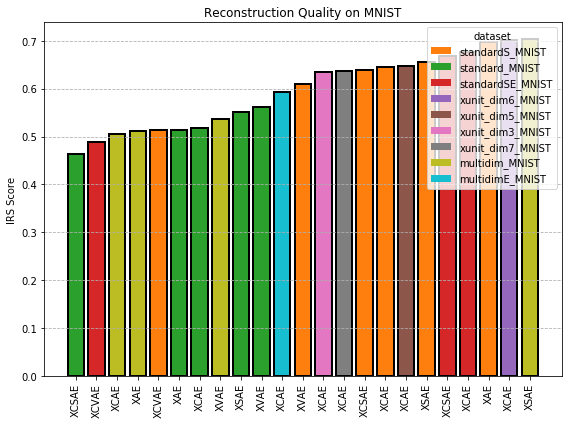

In [11]:
fig = plot_metrics(full_df, metric_name="IRS", key="dataset",value="MNIST", group_key="model_version",figsize=(8,6))
#fig = plot_metrics(full_df, metric_name="FID", key="dataset",value="3DS", group_key="model_version",figsize=(6,6))

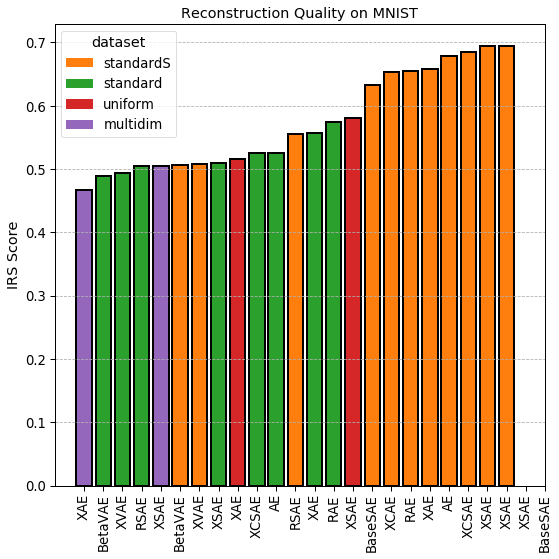

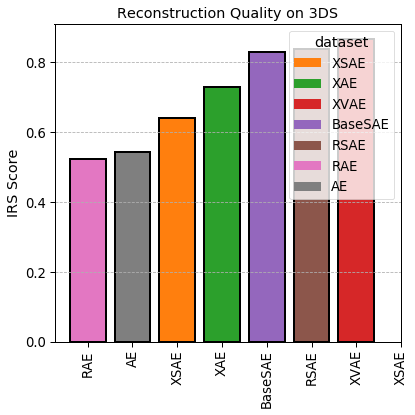

In [47]:
fig = plot_metrics(full_df, metric_name="IRS", key="dataset",value="MNIST", group_key="model_version",figsize=(8,8))
fig = plot_metrics(full_df, metric_name="IRS", key="dataset",value="3DS", group_key="model_name",figsize=(6,6))

In [ ]:
#TODO: adjust plotting for visual datasets

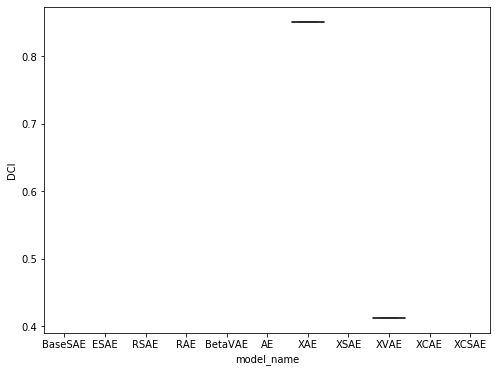

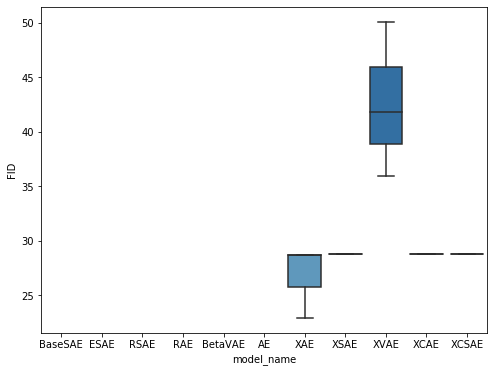

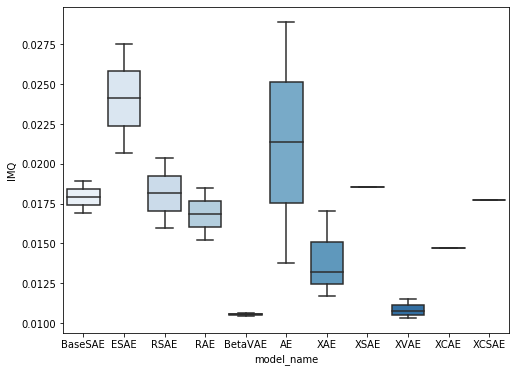

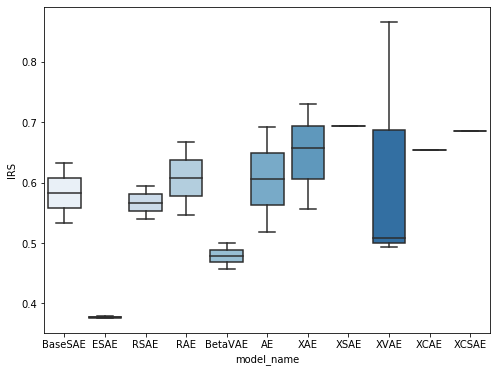

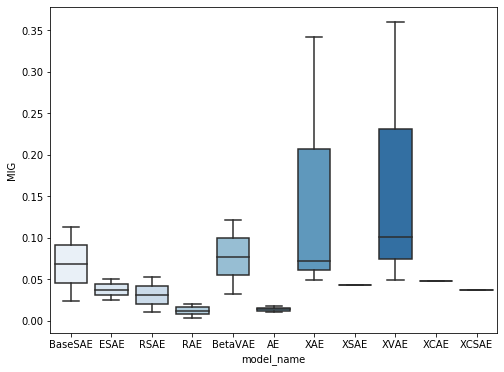

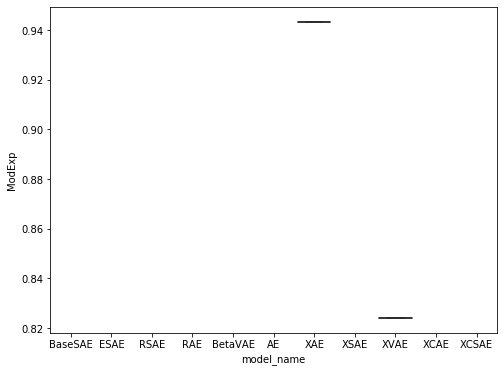

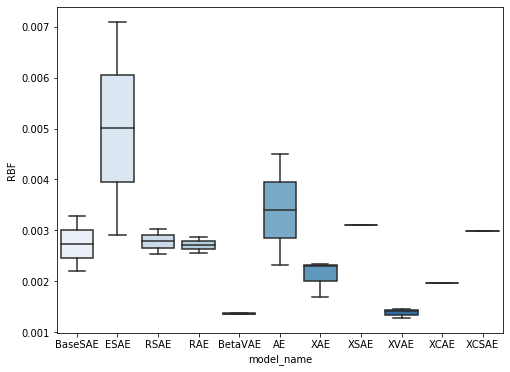

In [19]:
for k in full_df.columns[1:8]: # disentanglement
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='model_name',y=k,data=full_df,
                palette="Blues")

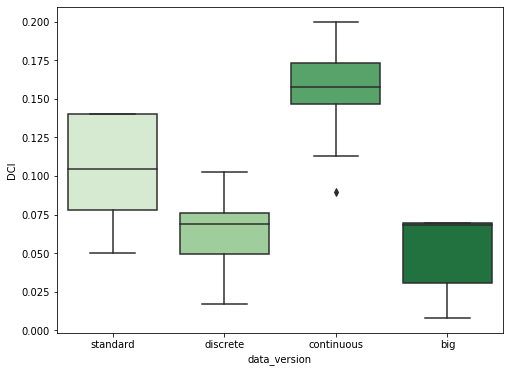

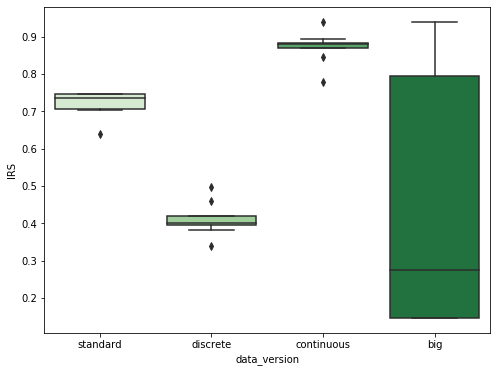

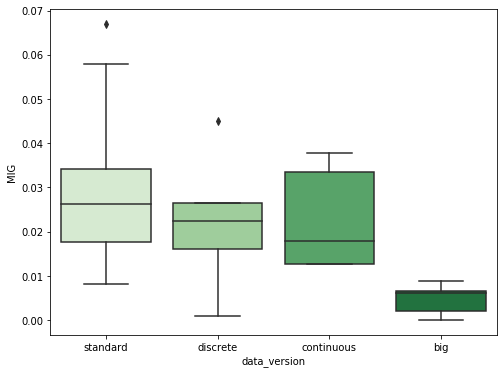

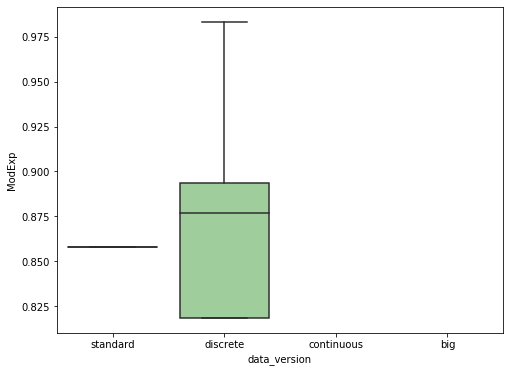

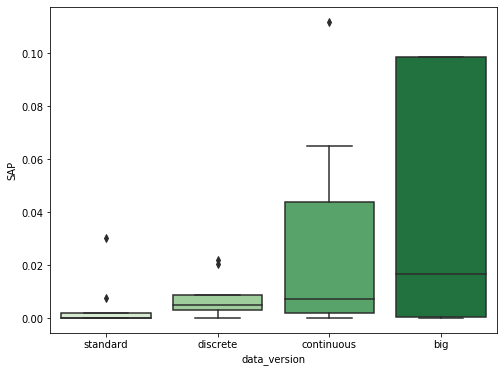

In [59]:
for k in scores_df.columns[3:]: # orthogonality
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='data_version',y=k,data=scores_df, palette="Greens")

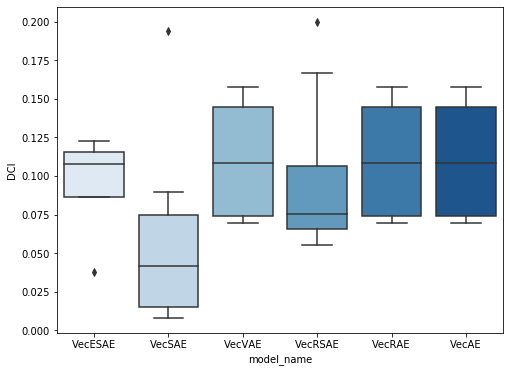

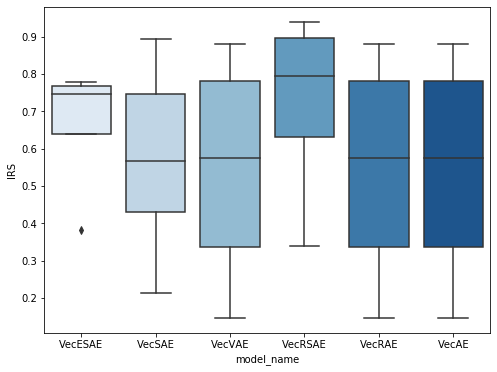

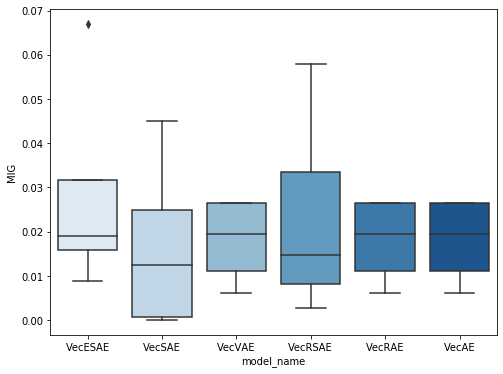

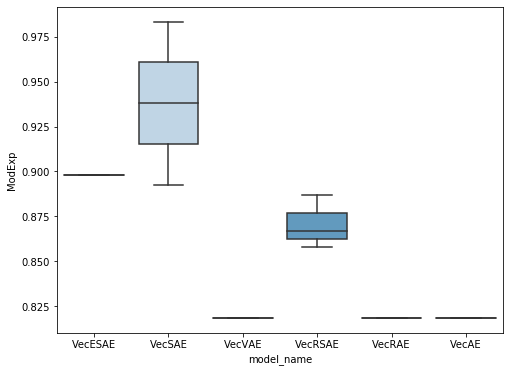

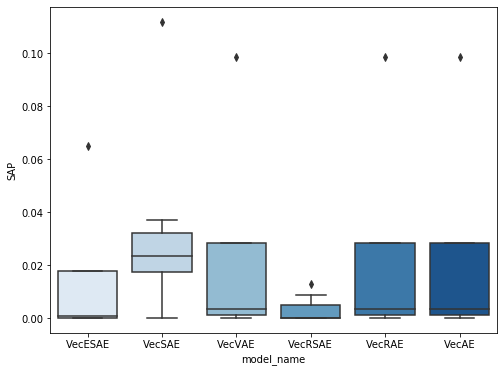

In [47]:
# finally visualising 
for k in scores_df.columns[3:]: # disentanglement
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='model_name',y=k,data=scores_df, palette="Blues")

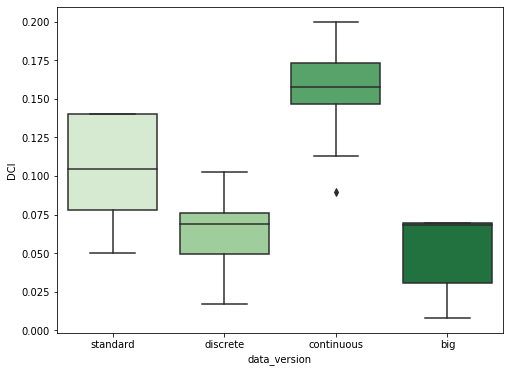

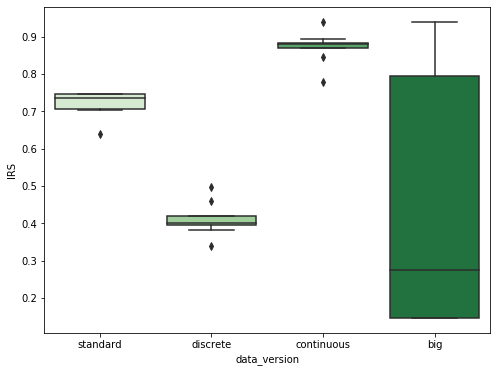

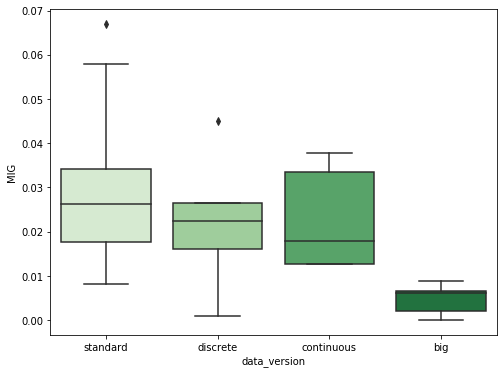

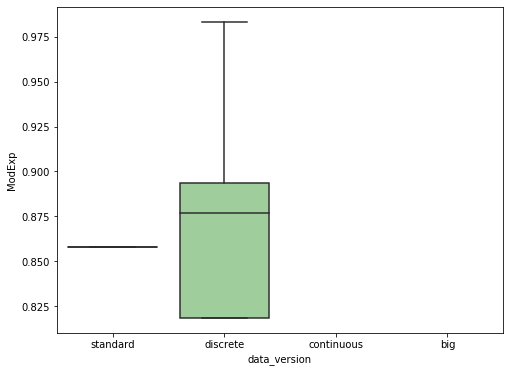

In [57]:
# finally visualising 
for k in scores_df.columns[3:-1]: # disentanglement
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='data_version',y=k,data=scores_df, palette="Greens")

# Invariance Scoring

In [43]:
params = {"model_name":"XCSAE",
          "model_version":"standardSE",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')

configs/models/XCSAE/standardSE.yaml
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCSAE model hanlder loaded.
Loading selected checkpoint at logs\XCSAE\standardSE_MNIST\checkpoints/final.ckpt
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
   

In [44]:
params= {
    'intervention_type':'noise',
    'num_interventions':100, 
    'num_samples':200,
    'store':True, 
    'load':False, # note: when load=True the std_devs and intv_mags are not returned
    'random_seed':23,
    'num_batches':10,
    'mode':'X',
    'normalise':False,
    'verbose':True}

invariance_matrix, std_devs = handler.evaluate_invariance(**params)

Scoring model's response map invariance to noise interventions.


Intervening on 0 ...
Intervening on 1 ...
Intervening on 2 ...
Intervening on 3 ...
Intervening on 4 ...
Intervening on 5 ...
Storing invariance evaluation results.


In [45]:
invariance_matrix

tensor([[0.1179, 0.9523, 0.8865, 0.8287, 0.9109, 0.9088],
        [0.6412, 0.0570, 0.7650, 0.6236, 0.7673, 0.7809],
        [0.8302, 0.9297, 0.0409, 0.7800, 0.8745, 0.8693],
        [0.9298, 0.9678, 0.9363, 0.0205, 0.9387, 0.9381],
        [0.8517, 0.9466, 0.8853, 0.8407, 0.0453, 0.8879],
        [0.8088, 0.9354, 0.8595, 0.7650, 0.8848, 0.0642]], device='cuda:0')

In [46]:
std_devs

tensor([[0.7834, 0.3304, 0.5450, 1.1047, 0.6769, 0.7953],
        [0.7165, 0.3287, 0.5335, 1.0867, 0.6588, 0.7530]], device='cuda:0')

In [47]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(8,6), "nrows":3, "N":100, "markersize":10, "font_scale":10}

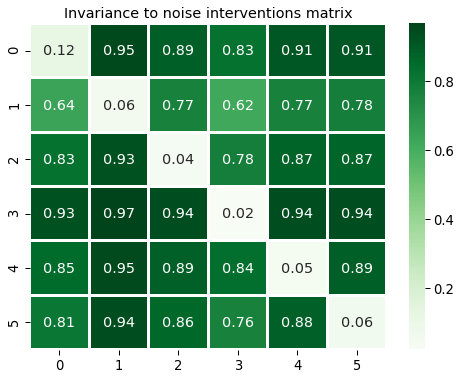

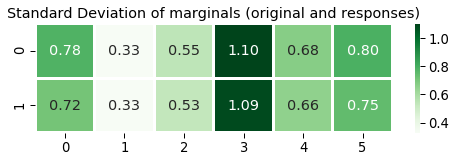

In [48]:
fig = handler.visualiser.plot_heatmap(invariance_matrix.cpu(), 
                                      title="Invariance to noise interventions matrix", 
                                      threshold=0., 
                                      **figure_params)
fig2 = handler.visualiser.plot_heatmap(std_devs.view(2,6).cpu(), 
                                      title="Standard Deviation of marginals (original and responses)", 
                                      threshold=0., figsize=(8,2))

In [49]:
print(torch.sum(invariance_matrix.cpu()*(1-torch.eye(6))))

tensor(25.7253)


In [35]:
torch.sum((((1. - invariance_matrix.cpu())*torch.eye(6)) + invariance_matrix.cpu()*(1-torch.eye(6))))

tensor(35.0255)

# Equivariance

In [85]:
params = {"model_name":"XAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint()

configs/models/XAE/standardS.yaml
Initialising schedulers Manager...
Explicit mode ON
XAE model hanlder loaded.
Loading latest checkpoint at logs\XAE\standardS_MNIST\checkpoints\epoch=197-step=65012.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        Max

In [86]:
params= {
    'intervention_type':'noise',
    'num_interventions':100, 
    'num_samples':100,
    'store':True, 
    'load':False, # note: when load=True the std_devs and intv_mags are not returned
    'random_seed':23,
    'num_batches':10,
    'mode':'X',
    'prior_mode':'posterior',
    'verbose':True}

equivariance_matrix = handler.evaluate_equivariance(**params)

Scoring model's response map equivariance to noise interventions.


Intervening on 0 ...
Intervening on 1 ...
Intervening on 2 ...
Intervening on 3 ...
Intervening on 4 ...
Intervening on 5 ...
Storing equivariance evaluation results.


In [87]:
equivariance_matrix

tensor([[0.9781, 0.9829, 0.9823, 0.9731, 0.9837, 0.9796],
        [0.9673, 0.9652, 0.9640, 0.9625, 0.9695, 0.9610],
        [0.9842, 0.9865, 0.9746, 0.9816, 0.9858, 0.9839],
        [0.9832, 0.9863, 0.9838, 0.9746, 0.9817, 0.9795],
        [0.9800, 0.9827, 0.9796, 0.9778, 0.9764, 0.9756],
        [0.9859, 0.9866, 0.9860, 0.9804, 0.9856, 0.9744]], device='cuda:0')

In [88]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(8,6), "nrows":3, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}

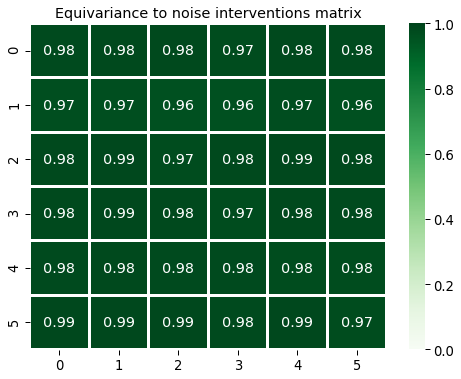

In [89]:
fig = handler.visualiser.plot_heatmap(equivariance_matrix.cpu(), 
                                      title="Equivariance to noise interventions matrix", 
                                      threshold=0., 
                                      **figure_params)

In [90]:
print(torch.sum(equivariance_matrix))

tensor(35.2260, device='cuda:0')


# Self-consistency

In [26]:
params = {"model_name":"XCSAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint()

configs/models/XCSAE/standardS.yaml
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCSAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCSAE\standardS_MNIST\checkpoints\epoch=293-step=96082.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32,

In [27]:
params= {'num_samples':100,
        'random_seed':23,
        'num_batches':10,
        'prior_mode':'hybrid',
        'normalise': False,
        'verbose':True, 
        'level':3}

consistency, std_dev = handler.evaluate_self_consistency(**params)

Scoring model's self consistency at level 3.


In [28]:
consistency

tensor([[0.8693, 0.9511, 0.9634, 0.8718, 0.8451, 0.9187],
        [0.8159, 0.9189, 0.9399, 0.8039, 0.7835, 0.8800],
        [0.7671, 0.8923, 0.9259, 0.7630, 0.7348, 0.8544]], device='cuda:0')

In [31]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(8,2), "nrows":3, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}

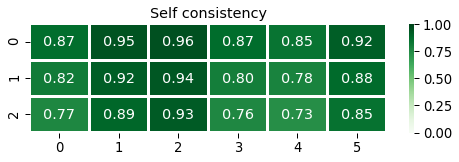

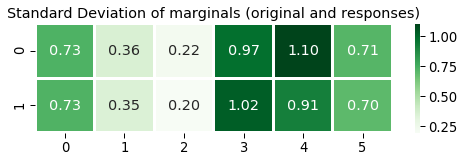

In [32]:
fig = handler.visualiser.plot_heatmap(consistency.view(3,-1).cpu(), 
                                      title="Self consistency", 
                                      threshold=0., 
                                      **figure_params)
fig2 = handler.visualiser.plot_heatmap(std_dev.view(2,6).cpu(), 
                                      title="Standard Deviation of marginals (original and responses)", 
                                      threshold=0., figsize=(8,2))